In the following, we tackle a case of participating in multiple auctions from a probabilistic perspective. We are willing to answer questions such as "In how many auctions should I participate in order to (likely) win $k$ auctions?".
There are multiple approaches to solving such a case. Here we would use Laplace's Rule of Succession, simple python simulations, and dynamic programming.

This approach could be applied to many other world case scenarios, with only little to no modifications.

More formally, assume that you have the option to make a bid at multiple auctions ($N$). For each auction, you could set the same bid price (amount of money/resources a buyer is willing to pay for security). 

However, given the bid price, every auction has its own probability of winning. 

So, what is the probability of winning $k$ auctions out of $N$?

If those probabilities were all the same (i.e., $p_i=p, \forall i \in \{1,..,N\}$), obviously, the answer would be a simple binomial distribution with $N,k,p$:
$$P(A) =  {{N}\choose{k}} \cdot p^k(1-p)^{N-k} $$

But what happens when probabilities are not the same?
How can we calculate the probability of observing a $k$ successful outcome in many auctions?
One approach would be to consider all win-lose combinations of auctions with k successful outcome, calculate the probability of each, and sum. 

For example, assume $N=3$ auctions, with $k=2$ as the desired number of successes, and the probabilities of independent trials $p_1, p_2, p_3$:


| Combination idx | Auction1 | Auction2 | Auction3 |
| :- | -: | :-: | :-: |
| $$1$$ | $$\text{win: }p_1$$ | $$\text{win: }p_2$$ | $$\text{lose: }1-p_3$$ |
| $$2$$ | $$\text{win: }p_1$$ | $$\text{lose: }1-p_2$$ | $$\text{win: }p_3$$ |
| $$3$$ | $$\text{lose: }1-p_1$$ | $$\text{win: }p_2$$ | $$\text{win: }p_3$$ |

which would be 
$$P(A)=p_1p_2(1-p_3)+p_1(1-p_2)p_3+(1-p_1)p_2p_3$$

However, when $N$ is high, complexity-wise, calculating $P(A)$ is cumbersome. More precisely, that would be factorial time complexity.
Since this is not feasible, we would have to think of something else.

**Moreover, what would we do when we do not have those probabilities?**
If one does not have the $p_i$'s, let's see how to estimate them.
Assuming we have $M_i$ independent samples of each of those auctions. For each auction, we could calculate the unbiased extimator of the proportion parameter $p_i$ as a Bernoulli distribution, which is simply: 
$$p_i = \frac{1}{N} \sum_{j=1}^{M_i} \unicode{x1D7D9}_{\text{success}}.$$ 
Similarly, one could suggest using Laplace's Rule of Succession: 
$$p=\frac{1+\sum_{j=1}^{M_i} \unicode{x1D7D9}_{\text{success}}}{N+2},$$
which, mostly, is more useful. 
For large $N$, the two estimations are pretty close. However, for a small number of trials, the latter is preferable.


So now we are in the position to ask the question of: In how many auctions should I place a bid, if I want to win at $k$ auctions?
Again, for simplicity, we assume in each auction we set the same bid price.


When all bid prices are the same, and our goal is to reduce costs, one can prove that the optimal solution prefers auctions with high probabilities of winning. So first, we sort the auctions by probability.

If we were not to assume the same bid prices, we would have to order (NP-complete) the auctions. Then we would apply our algorithm to find the best set of auctions to participate. However, that is not feasible.

We cannot just normalize the probability of success by the bid-price, and solve since it does not guarantee an optimal solution (but just a greedy one).

Let's try a simple simulation, generate some data, and see how it behaves.

In [22]:
import numpy as np 
np.random.seed(1)
N = 50
#generate random probabilities of N auctions.
#we randomize them to be between 0 to 0.5,
ps = np.random.randint(low=0, high=1001, size=N)/2000
#sort
ps.sort()

In [23]:
#approximation of the pdf of having k 1's out of N. k in {0,..,N}
M = 10**5
dist = np.zeros(N+1)
for i in range(M):
    vec = np.random.binomial(1, p=ps)
    vec_sum = vec.sum()
    dist[vec_sum] +=1
dist = dist/M
#dist is now an approximation of the pdf
print(dist.tolist())

[0.0, 0.0, 5e-05, 0.00021, 0.0009, 0.00301, 0.00798, 0.01874, 0.03838, 0.06354, 0.09349, 0.11889, 0.13401, 0.13391, 0.12251, 0.0962, 0.07104, 0.04511, 0.02656, 0.01371, 0.00682, 0.00298, 0.00122, 0.00047, 0.0002, 4e-05, 3e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


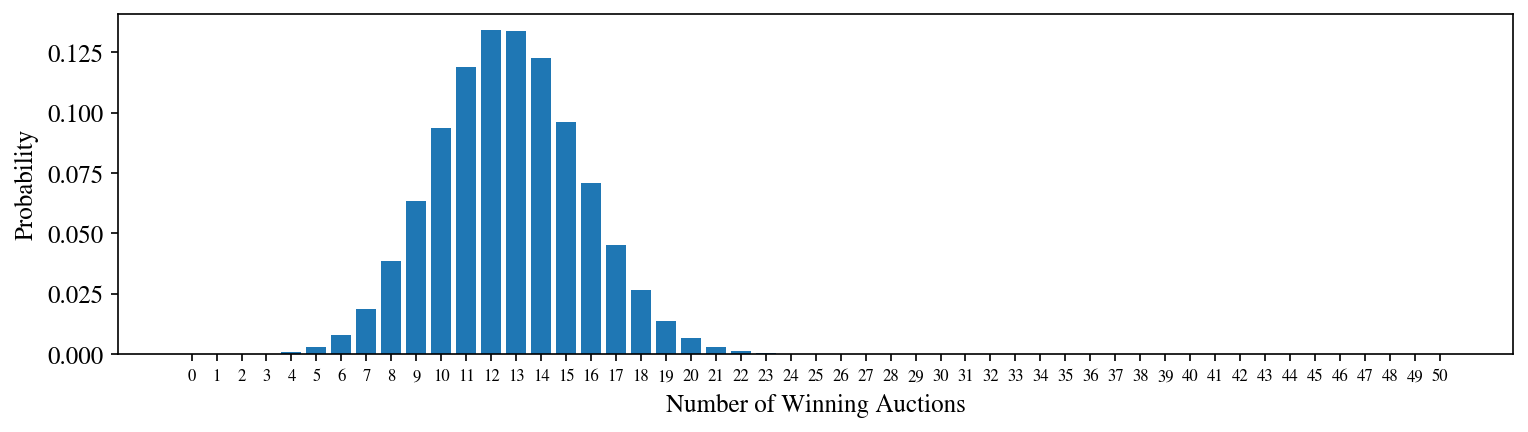

In [24]:
import matplotlib
import matplotlib.pyplot as plt 
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = '12'
matplotlib.rcParams['figure.figsize'] = [12., 3.]
matplotlib.rcParams['figure.dpi'] = 150

plt.bar(np.arange(N+1), dist)
plt.xticks(np.arange(N+1), fontsize=8, rotation=0)

plt.ylabel('Probability')
plt.xlabel('Number of Winning Auctions')
plt.show()

The above chart heavily depends on the probability (which were randomized $\in (0,0.5)$ for this example). Higher numbers as $p_i$'s would directly skew the ampirical distribution to the right.

Besides approximating those by running M trails, we could calculate the exact numbers. This would be done by **dynamic programming**.
Instead of distinctively calculating the probability of each combination of auctions, we could spare many calculations by "caching" the solutions to smaller problems. Meaning, we break down our problem into simpler subproblems and utilize the fact that the optimal solution to our main problem depends upon the optimal solution to its subproblems. 
Let $DP(N,k)$ denote the probability of $k$ successful outcome out of $N$. Then, by the low of total probability:

$$DP(T,k) = p_{T-1}DP(T-1,k-1) + (1-p_T)DP(T-1,k), \forall T \in \{2,..,N\}$$

Based on the resulting $DP$ matrix, we could answer the questions above.

In [25]:
#DP
# f(N,k) = pi*f(N-1,k-1) + (1-pi)*f(N-1,k)
# f(i,j)=0 for all i<j
# f(0,j)=0 for all j
#
#k     |0 1 2 3 4 5 6
#       _____________
#N 0 5 |x - - - - - - 
#  1 4 |x - - - - - - 
#  2 3 |x - - - - - -
#  3 2 |x - - - - - - 
#  4 1 |x x 0 0 0 0 0

#f(N=T,k=0) = PI_{i=1}^T (1-pi)
#f(N=1,k=1) = p_1 and f(N=1,k=k)=0 forall 1<k<N

In [26]:
DP = np.zeros((N,N+1))

#O(N) operations - first column
DP[-1,0] = 1-ps[-1]
for n in range(N-1):
    DP[-2-n,0] = DP[-1-n,0] * (1-ps[-2-n])

#O(N) operations - last row
DP[-1,1] = ps[-1]
for j in range(2,N+1):
    DP[-1,j] = 0

#O(N^2) operations
for n in range(N-1): #N
    for j in range(1,N+1): #k
        DP[-2-n,j] = ps[-2-n]*DP[-1-n,j-1] + (1-ps[-2-n])*DP[-1-n,j]

In [27]:
#for dp in DP:
#    print(dp.tolist())

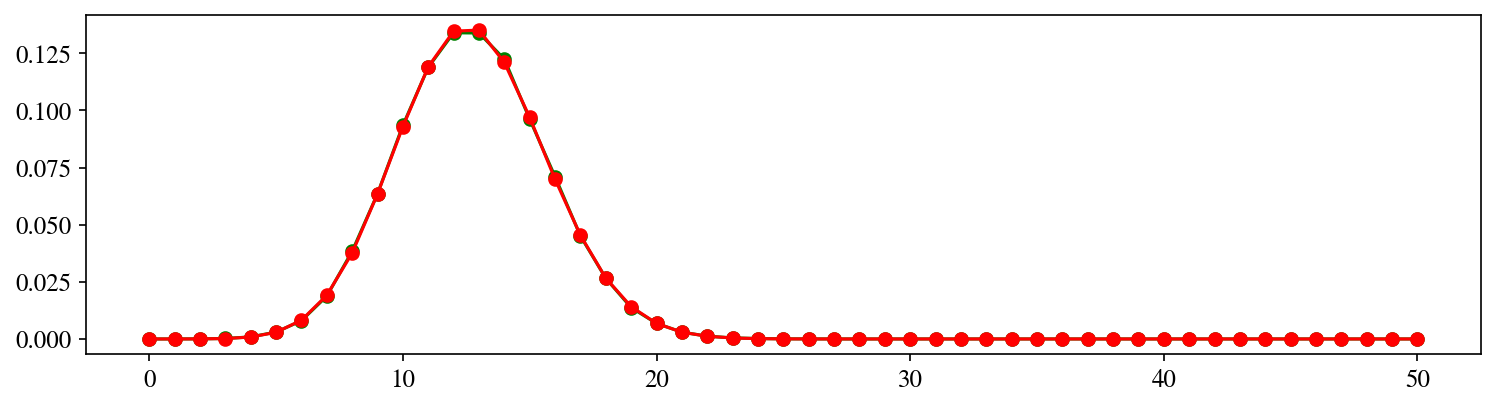

In [28]:
#compare the amperical results and the calculated results of N=N, for all k.
plt.plot(dist, color='g', marker='o')
plt.plot(DP[0], color='r', marker='o')
plt.show()

Let's see how many cycles it take the simulation to converge to the above result.

In [33]:
#approximation of the pdf of having k 1's out of N. k in {0,..,N}, for a given number of samples S.
S = 5

dist_m = np.zeros((S,N+1))
arr = np.zeros(S)
for s in range(S):
    dist = np.zeros(N+1)
    M = 100**2 * (2*s+1)/S #modify in order to get different points to sample.
    arr[s] = M
    for i in range(int(M)):
        vec = np.random.binomial(1, p=ps)
        vec_sum = vec.sum()
        dist[vec_sum] +=1
    dist_m[s] = dist/M

#print(dist_m.tolist())

mse = (np.square(dist_m - DP[0])).mean(axis=1)
#print(mse)

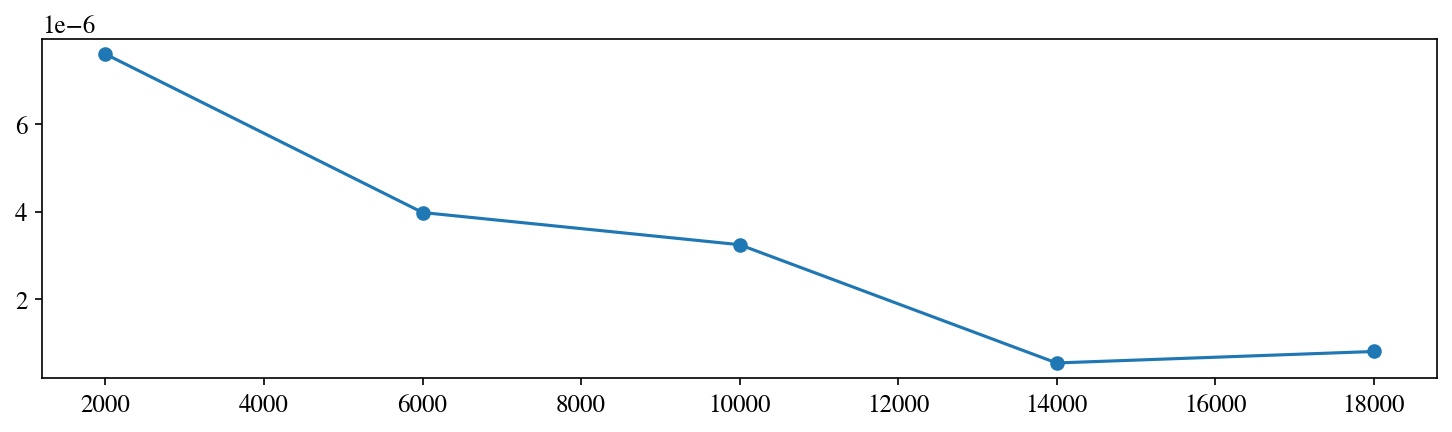

In [35]:
#plot the mse error vs # samples
plt.plot(arr, mse, linestyle=None, marker='o')
plt.show()